# Cosmology with one galaxy using mixture density networks

The goal of this notebook is to reproduce the results of the paper "Cosmology with 1 galaxy". We are going to use the CAMELS simulation suite to estimate the matter density of the universe ($\Omega_{M}$) uisng observable properties of galaxies.

Before starting the notebook, you can read about the CAMELS simualtion.

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers as tfkl
import cosmo_1_galaxy
import tensorflow_probability as tfp
import seaborn as sns


# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

tf.config.experimental.set_visible_devices([], 'GPU')

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

#import h5py

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.13.0
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [124]:
version ='1.0.0'
data_dir='/Users/marchuertascompany/Documents/python_scripts/camels/tensorflow_datasets'

dset_train = tfds.load('cosmo_1_galaxy:'+version,split='train',data_dir=data_dir)
dset_test = tfds.load('cosmo_1_galaxy:'+version,split='test',data_dir=data_dir)
dset_valid = tfds.load('cosmo_1_galaxy:'+version,split='valid',data_dir=data_dir)

This is just a list of the observable properties 

[0,1,2,6,7,8,9,10,11,14,15,16]

gal_prop[count:count+Ngal,0]  = Mg[indexes]
gal_prop[count:count+Ngal,1]  = Mstar[indexes]
gal_prop[count:count+Ngal,2]  = Mbh[indexes]
gal_prop[count:count+Ngal,3]  = Mtot[indexes]
gal_prop[count:count+Ngal,4]  = Vmax[indexes]
gal_prop[count:count+Ngal,5]  = Vdisp[indexes]
gal_prop[count:count+Ngal,6]  = Zg[indexes]
gal_prop[count:count+Ngal,7]  = Zs[indexes]
gal_prop[count:count+Ngal,8]  = SFR[indexes]
gal_prop[count:count+Ngal,9]  = J[indexes]
gal_prop[count:count+Ngal,10] = V[indexes]
gal_prop[count:count+Ngal,11] = Rstar[indexes]
gal_prop[count:count+Ngal,12] = Rtot[indexes]
gal_prop[count:count+Ngal,13] = Rvmax[indexes]
gal_prop[count:count+Ngal,14] = U[indexes]
gal_prop[count:count+Ngal,15] = K[indexes]
gal_prop[count:count+Ngal,16] = g[indexes]



Let's plot some galaxy properties against cosmological parameters

2023-08-20 16:09:27.215878: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-08-20 16:09:27.255273: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-08-20 16:09:27.288866: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

<Figure size 800x600 with 0 Axes>

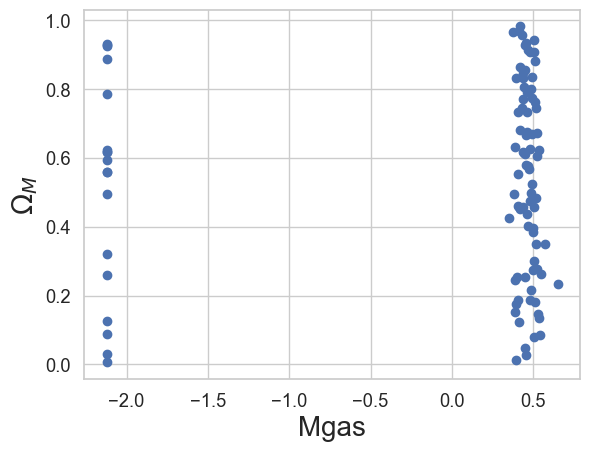

<Figure size 800x600 with 0 Axes>

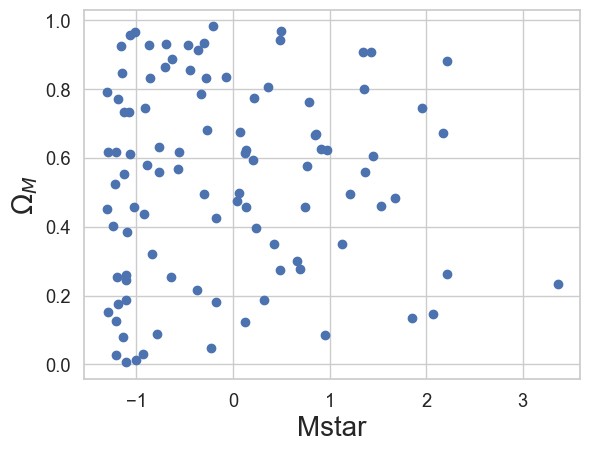

<Figure size 800x600 with 0 Axes>

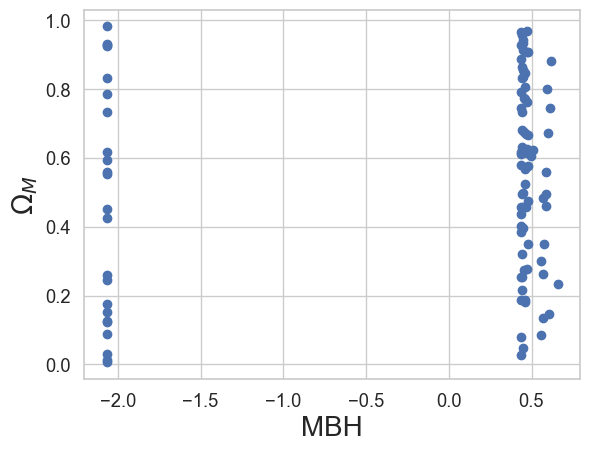

<Figure size 800x600 with 0 Axes>

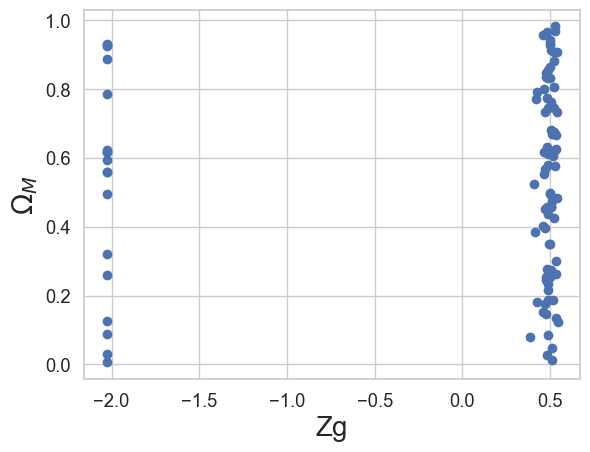

<Figure size 800x600 with 0 Axes>

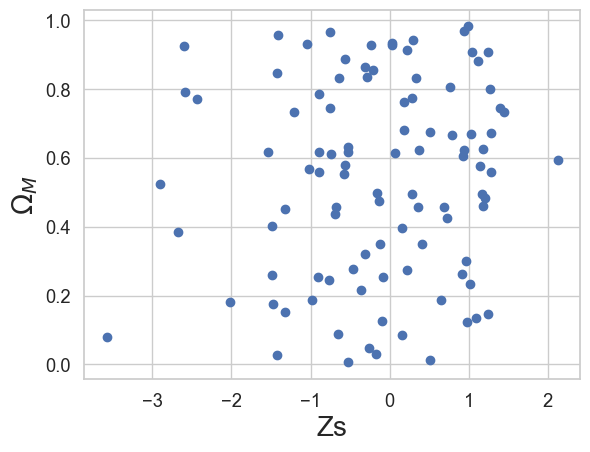

<Figure size 800x600 with 0 Axes>

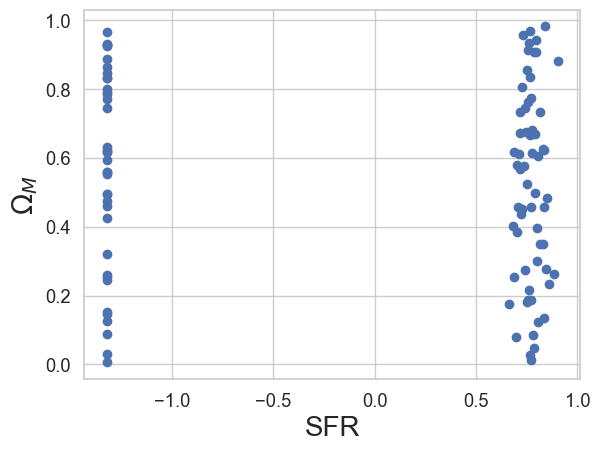

<Figure size 800x600 with 0 Axes>

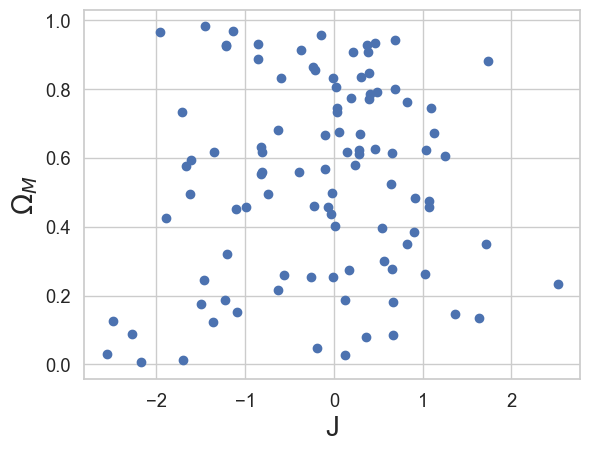

<Figure size 800x600 with 0 Axes>

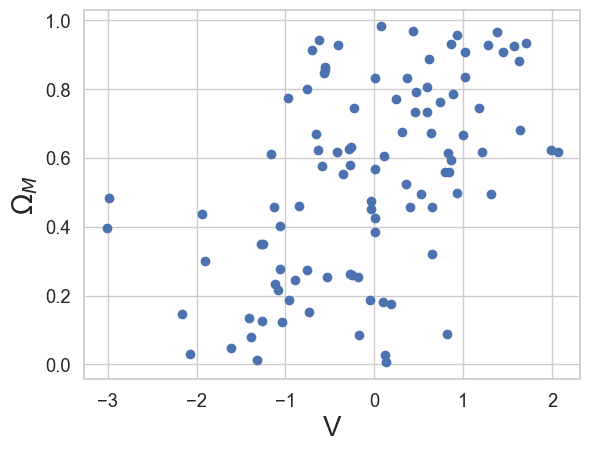

<Figure size 800x600 with 0 Axes>

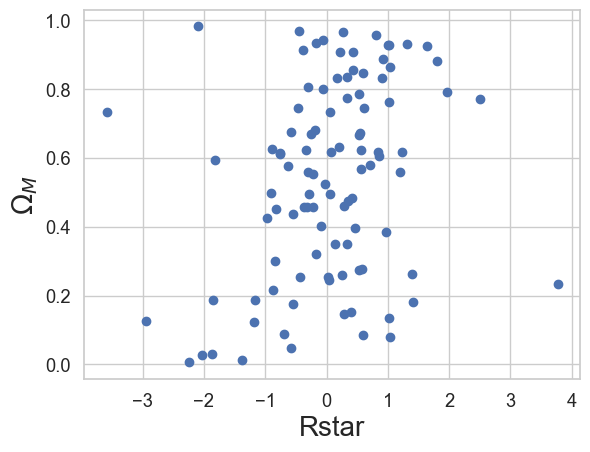

<Figure size 800x600 with 0 Axes>

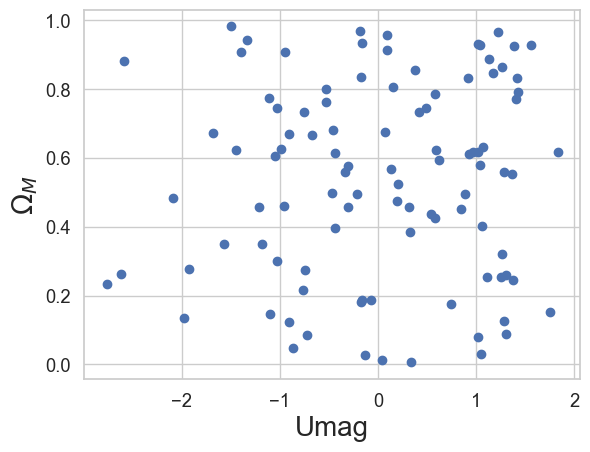

<Figure size 800x600 with 0 Axes>

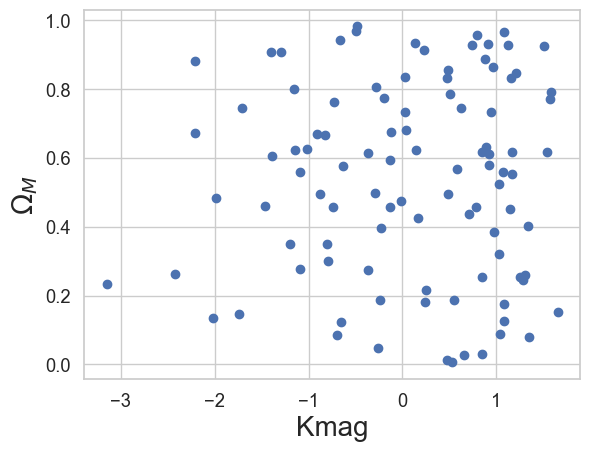

<Figure size 800x600 with 0 Axes>

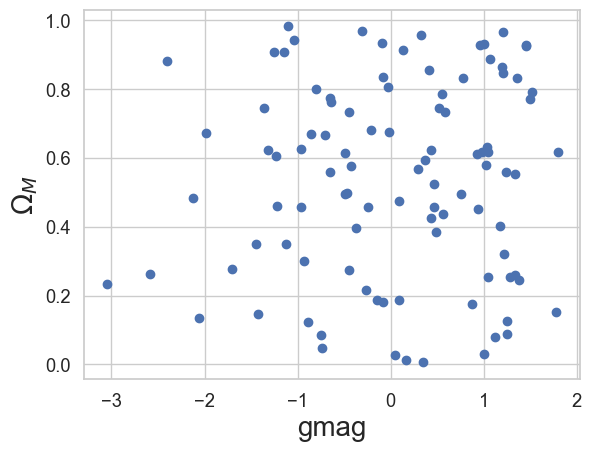

In [125]:
galprop=["Mgas","Mstar","MBH","Zg","Zs","SFR","J","V","Rstar","Umag","Kmag","gmag"]
cosmo=["$\Omega_M$","$\sigma_8$","$A_{SN1}$","$A_{SN2}$","$A_{AGN1}$","$A_{AGN2}$"]


         #,"Rstar","Rtot","Rvmax","Umag","Kmag","gmag"]

cosmo_ind = 0 # this contains omega matter


for galprop_ind,lbl in zip(range(len(galprop)),galprop):
    galpropvec=[]
    cosmovec=[]
    for example in dset_train.take(100):
        galpropvec.append(example['input'][galprop_ind].numpy())
        cosmovec.append(example['output'][cosmo_ind].numpy())
    #print(example['output'][0])
    # Create a line plot using Seaborn
    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(8, 6))
    plt.figure()
    plt.scatter(galpropvec,cosmovec)
    plt.xlabel(lbl,fontsize=20)
    plt.ylabel(cosmo[cosmo_ind],fontsize=20)
    

# Part 1: Simple MLP

Model definition. Simple MLP. We use a standard mean square error loss.

In [129]:
def Model():
    """ Creates a small fully connected network
    """
    return tf.keras.Sequential([
        tfkl.Input(shape=(12)),
        tfkl.Dense(16, activation='relu'),
        tfkl.Dense(32, activation='relu'),
        tfkl.Dense(64, activation='relu'),
        tfkl.Dense(128, activation='relu'),
        tfkl.Dense(1)
        ])


mlp = Model()
mlp.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
              loss=tf.keras.losses.MSE)

Main function for preparing datasets

In [130]:
def preprocessing(x,y):
    galprop = x
    cosmo = y[:,0]
    return galprop, cosmo

def input_fn(mode='train', batch_size=64):
    """
    mode: 'train', test' or 'val'
    """
    keys = ['input','output']
    if mode == 'train':
        dataset = tfds.load('cosmo_1_galaxy',split='train',data_dir=data_dir)
        dataset = dataset.map(lambda x: (x['input'], x['output']))
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
        dataset = dataset.batch(batch_size, drop_remainder=True)
    if mode == 'val':
        dataset = tfds.load('cosmo_1_galaxy',split='valid',data_dir=data_dir)
        dataset = dataset.map(lambda x: (x['input'], x['output']))
        dataset = dataset.batch(batch_size, drop_remainder=True)
    if mode == 'test':
        dataset = tfds.load('cosmo_1_galaxy',split='test',data_dir=data_dir)
        dataset = dataset.map(lambda x: (x['input'], x['output']))
        dataset = dataset.batch(batch_size, drop_remainder=False)
        

    
    dataset = dataset.map(preprocessing) # Apply data preprocessing
    dataset = dataset.prefetch(-1)  # fetch next batches while training current one (-1 for autotune)
    return dataset

Training the network

In [131]:
dset_train = input_fn()
dset_val = input_fn(mode='val')
history = mlp.fit(dset_train, validation_data=dset_val,epochs=20,steps_per_epoch=1000)

Epoch 1/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0446 - val_loss: 0.0451
Epoch 2/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0360 - val_loss: 0.0360
Epoch 3/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0345 - val_loss: 0.0355
Epoch 4/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0335 - val_loss: 0.0329
Epoch 5/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0331 - val_loss: 0.0357
Epoch 6/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0323 - val_loss: 0.0333
Epoch 7/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0322 - val_loss: 0.0325
Epoch 8/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0321 - val_loss: 0.0327
Epoch 9/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0318 - val_loss: 0.0323
Epoch 10/20
1000/1000 [==============================] - 1s 833us/step - loss: 0.0

Plot the results for the test set

556/556 [==============================] - 0s 735us/step


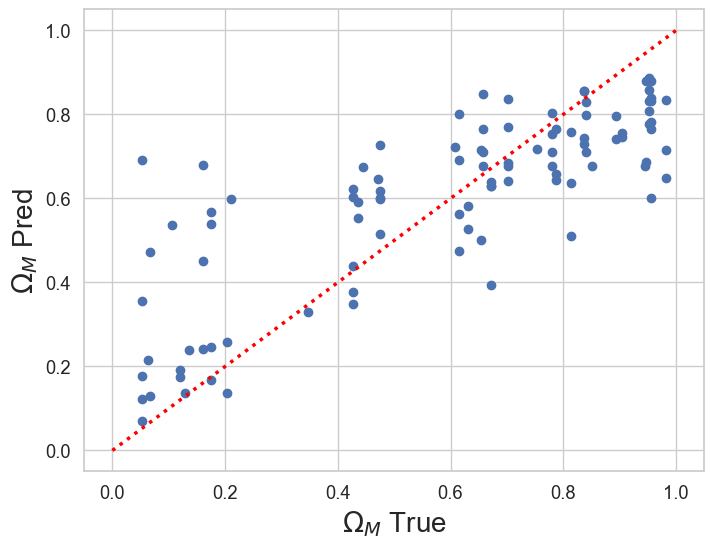

In [135]:
dset_test = input_fn(mode='test')
omega_pred = mlp.predict(dset_test)


omega_test=[]
dset_test = tfds.load('cosmo_1_galaxy',split='test',data_dir=data_dir)
for example in dset_test.take(-1):
    omega_test.append(example['output'][0].numpy())
    


# Create a line plot using Seaborn
sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(8, 6))
plt.scatter(omega_test[0:100],omega_pred[0:100])
plt.xlabel("$\Omega_M$ True",fontsize=20)
plt.ylabel("$\Omega_M$ Pred",fontsize=20)

plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),color='red',ls=':')

# Part 2: Mixture Density Network

Model definition. We replace the last layer with a probablisitc layer

In [137]:
tfd = tfp.distributions
tfb = tfp.bijectors
tfkl = tf.keras.layers

num_components = 1
event_shape = [1]

params_size = tfp.layers.MixtureSameFamily.params_size(
    num_components,
    component_params_size=tfp.layers.IndependentNormal.params_size(event_shape))

mdn = tf.keras.Sequential([
        tfkl.Input(shape=(12)),
        tfkl.Dense(16, activation='LeakyReLU'),
        tfkl.Dropout(0.2),
        tfkl.Dense(32, activation='LeakyReLU'),
        tfkl.Dropout(0.2),
        tfkl.Dense(64, activation='LeakyReLU'),
        tfkl.Dropout(0.2),
        tfkl.Dense(128, activation='LeakyReLU'),
        tfkl.Dropout(0.2),
        tfkl.Dense(units=params_size, activation=None),
        tfp.layers.MixtureSameFamily(num_components, tfp.layers.IndependentNormal(event_shape))
])

negloglik = lambda y, p_y: -p_y.log_prob(y)


opt = tf.keras.optimizers.Adam(learning_rate=0.0002)
mdn.compile(loss=negloglik, optimizer=opt)

In [138]:
dset_train = input_fn()
dset_val = input_fn(mode='val')
history = mdn.fit(dset_train, validation_data=dset_val,epochs=200,steps_per_epoch=3000)

Epoch 1/200
3000/3000 [==============================] - 4s 1ms/step - loss: 0.0430 - val_loss: -0.1135
Epoch 2/200
3000/3000 [==============================] - 4s 1ms/step - loss: -0.1209 - val_loss: -0.1797
Epoch 3/200
3000/3000 [==============================] - 3s 1ms/step - loss: -0.1623 - val_loss: -0.2054
Epoch 4/200
3000/3000 [==============================] - 3s 852us/step - loss: -0.1809 - val_loss: -0.2373
Epoch 5/200
3000/3000 [==============================] - 3s 836us/step - loss: -0.2003 - val_loss: -0.2626
Epoch 6/200
3000/3000 [==============================] - 2s 833us/step - loss: -0.2143 - val_loss: -0.2726
Epoch 7/200
3000/3000 [==============================] - 2s 817us/step - loss: -0.2215 - val_loss: -0.2905
Epoch 8/200
3000/3000 [==============================] - 2s 817us/step - loss: -0.2276 - val_loss: -0.2924
Epoch 9/200
3000/3000 [==============================] - 2s 818us/step - loss: -0.2393 - val_loss: -0.2955
Epoch 10/200
3000/3000 [====================

3000/3000 [==============================] - 2s 833us/step - loss: -0.2940 - val_loss: -0.3610
Epoch 78/200
3000/3000 [==============================] - 3s 850us/step - loss: -0.2986 - val_loss: -0.3492
Epoch 79/200
3000/3000 [==============================] - 3s 839us/step - loss: -0.3009 - val_loss: -0.3548
Epoch 80/200
3000/3000 [==============================] - 3s 835us/step - loss: -0.2939 - val_loss: -0.3432
Epoch 81/200
3000/3000 [==============================] - 3s 877us/step - loss: -0.2998 - val_loss: -0.3338
Epoch 82/200
3000/3000 [==============================] - 3s 834us/step - loss: -0.2982 - val_loss: -0.3546
Epoch 83/200
3000/3000 [==============================] - 3s 841us/step - loss: -0.2983 - val_loss: -0.3514
Epoch 84/200
3000/3000 [==============================] - 3s 842us/step - loss: -0.2990 - val_loss: -0.3534
Epoch 85/200
3000/3000 [==============================] - 3s 844us/step - loss: -0.3009 - val_loss: -0.3459
Epoch 86/200
3000/3000 [=================

3000/3000 [==============================] - 2s 830us/step - loss: -0.3055 - val_loss: -0.3297
Epoch 153/200
3000/3000 [==============================] - 3s 854us/step - loss: -0.3018 - val_loss: -0.3471
Epoch 154/200
3000/3000 [==============================] - 3s 839us/step - loss: -0.3053 - val_loss: -0.3290
Epoch 155/200
3000/3000 [==============================] - 2s 832us/step - loss: -0.3065 - val_loss: -0.3469
Epoch 156/200
3000/3000 [==============================] - 3s 841us/step - loss: -0.3022 - val_loss: -0.3539
Epoch 157/200
3000/3000 [==============================] - 2s 830us/step - loss: -0.3033 - val_loss: -0.3579
Epoch 158/200
3000/3000 [==============================] - 3s 837us/step - loss: -0.3053 - val_loss: -0.3358
Epoch 159/200
3000/3000 [==============================] - 3s 843us/step - loss: -0.3020 - val_loss: -0.3358
Epoch 160/200
3000/3000 [==============================] - 2s 832us/step - loss: -0.3030 - val_loss: -0.3550
Epoch 161/200
3000/3000 [========

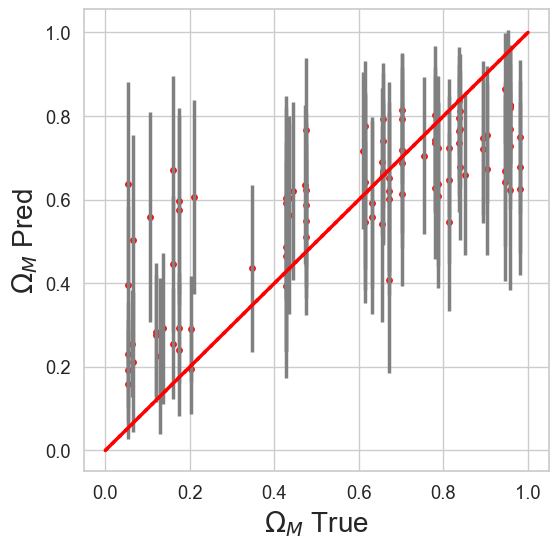

In [140]:
dset_test = input_fn(mode='test')
omega_pred_mean = np.concatenate([mdn(batch[0]).mean() for batch in dset_test])
omega_pred_std = np.concatenate([mdn(batch[0]).stddev() for batch in dset_test])

omega_test=[]
dset_test = tfds.load('cosmo_1_galaxy',split='test',data_dir=data_dir)
for example in dset_test.take(-1):
    omega_test.append(example['output'][0].numpy())
    
    
# Create a line plot using Seaborn
sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(6, 6))    
plt.errorbar(np.squeeze(omega_test[0:100]),np.squeeze(omega_pred_mean[0:100]),yerr=np.squeeze(omega_pred_std[0:100]),color='gray',fmt="none")
plt.scatter(omega_test[0:100],omega_pred_mean[0:100],color='red',s=15)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),color='red')
plt.xlabel("$\Omega_M$ True",fontsize=20)
plt.ylabel("$\Omega_M$ Pred",fontsize=20)

plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),color='red',ls=':')

We now plot some posterior distributions (assumed to be Gaussian)

2023-08-20 16:27:28.345813: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


<Figure size 400x400 with 0 Axes>

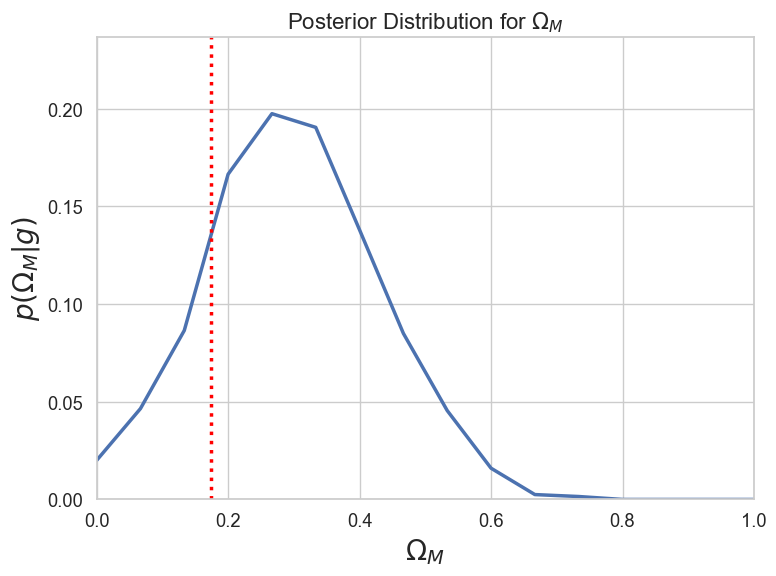

In [141]:
dset_test = input_fn(mode='test')
iterator = iter(dset_test)





nplots=1
for b in range(nplots):
    batch = iterator.get_next()
    nsamples=2000
    omega_pred_samples=[]
    for i in range(nsamples):
        omega_pred_samples.append((mdn(batch[0]).sample())[b])


    # Create a normalized histogram using Seaborn
    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(4, 4))




    # Compute the PDF using a normalized histogram
    hist, bin_edges = np.histogram(np.squeeze(np.array(omega_pred_samples)), bins=30, density=True,range=(-0.5, 1.5))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    pdf = hist * np.diff(bin_edges)

    # Create a line plot using Seaborn
    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(8, 6))

    # Plot the PDF as a line plot
    sns.lineplot(x=bin_centers, y=pdf, color="b")
    plt.xlabel(r"$\Omega_M$", fontsize=20)
    plt.ylabel(r"$p(\Omega_M|g)$", fontsize=20)
    plt.title("Posterior Distribution for $\Omega_M$", fontsize=16)
    plt.xlim(0, 1)
    plt.ylim(0, max(pdf) * 1.2)  # Adjust y-axis limits as needed

    plt.axvline(x=batch[1][b],color='red',ls=':')

    # Save or show the plot
    plt.tight_layout()
    plt.savefig("omega_pdf_plot.png")  # Save the plot to a file
    plt.show()  # Display the plot

# Part 3: Estimate $\sigma_8$ and $\Omega_{M}$ with a Multivariate Gaussian

We need to modify the function that creates the input data to include 

In [142]:
def preprocessing(x,y):
    galprop = x
    cosmo = y[:,0:2] # we now include omega_m and sigma_8 here
    return galprop, cosmo

def input_fn_omega_sigma8(mode='train', batch_size=64):
    """
    mode: 'train', test' or 'val'
    """
    keys = ['input','output']
    if mode == 'train':
        dataset = tfds.load('cosmo_1_galaxy',split='train',data_dir=data_dir)
        dataset = dataset.map(lambda x: (x['input'], x['output']))
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
        dataset = dataset.batch(batch_size, drop_remainder=True)
    if mode == 'val':
        dataset = tfds.load('cosmo_1_galaxy',split='valid',data_dir=data_dir)
        dataset = dataset.map(lambda x: (x['input'], x['output']))
        dataset = dataset.batch(batch_size, drop_remainder=True)
    if mode == 'test':
        dataset = tfds.load('cosmo_1_galaxy',split='test',data_dir=data_dir)
        dataset = dataset.map(lambda x: (x['input'], x['output']))
        dataset = dataset.batch(batch_size, drop_remainder=False)
        

    
    dataset = dataset.map(preprocessing) # Apply data preprocessing
    dataset = dataset.prefetch(-1)  # fetch next batches while training current one (-1 for autotune)
    return dataset

In [143]:
tfd = tfp.distributions
tfb = tfp.bijectors
tfkl = tf.keras.layers

num_components = 1
event_shape = 2

params_size = tfp.layers.MultivariateNormalTriL.params_size(event_shape)

mdn_multivariate = tf.keras.Sequential([
        tfkl.Input(shape=(12)),
        tfkl.Dense(16, activation='LeakyReLU'),
        tfkl.Dropout(0.2),
        tfkl.Dense(32, activation='LeakyReLU'),
        tfkl.Dropout(0.2),
        tfkl.Dense(64, activation='LeakyReLU'),
        tfkl.Dropout(0.2),
        tfkl.Dense(128, activation='LeakyReLU'),
        tfkl.Dropout(0.2),
        tfkl.Dense(units=params_size, activation=None),
        tfp.layers.MultivariateNormalTriL(event_shape)
])

negloglik = lambda y, p_y: -p_y.log_prob(y)


opt = tf.keras.optimizers.Adam(learning_rate=0.0002)
mdn_multivariate.compile(loss=negloglik, optimizer=opt)





In [144]:
dset_train = input_fn_omega_sigma8()
dset_val = input_fn_omega_sigma8(mode='val')
history = mdn_multivariate.fit(dset_train, validation_data=dset_val,epochs=20,steps_per_epoch=3000)

Epoch 1/20
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4638 - val_loss: 0.0668
Epoch 2/20
3000/3000 [==============================] - 4s 1ms/step - loss: 0.0976 - val_loss: -0.0306
Epoch 3/20
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0396 - val_loss: -0.0596
Epoch 4/20
3000/3000 [==============================] - 3s 922us/step - loss: 0.0130 - val_loss: -0.1000
Epoch 5/20
3000/3000 [==============================] - 3s 865us/step - loss: -0.0076 - val_loss: -0.1143
Epoch 6/20
3000/3000 [==============================] - 3s 860us/step - loss: -0.0274 - val_loss: -0.1354
Epoch 7/20
3000/3000 [==============================] - 3s 859us/step - loss: -0.0351 - val_loss: -0.1458
Epoch 8/20
3000/3000 [==============================] - 3s 874us/step - loss: -0.0459 - val_loss: -0.1739
Epoch 9/20
3000/3000 [==============================] - 3s 863us/step - loss: -0.0595 - val_loss: -0.1655
Epoch 10/20
3000/3000 [==============================] - 

Plot the results

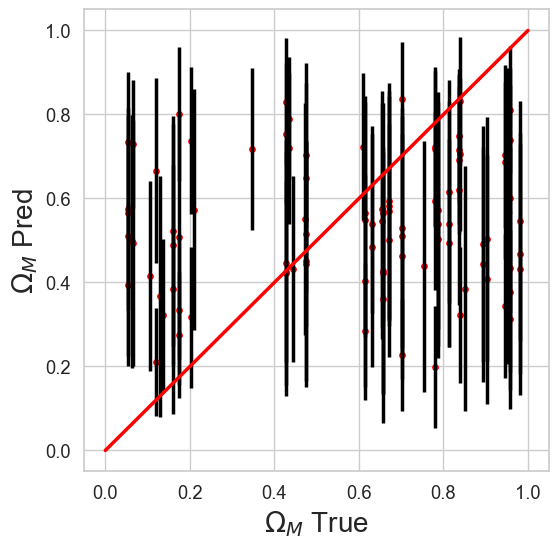

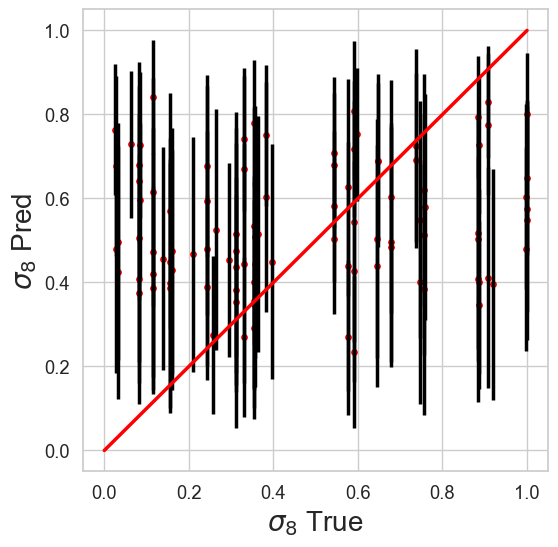

In [146]:
dset_test = input_fn_omega_sigma8(mode='test')
omega_pred_mean = np.concatenate([mdn_multivariate(batch[0]).mean()[0] for batch in dset_test])
omega_pred_std = np.concatenate([mdn_multivariate(batch[0]).stddev()[0] for batch in dset_test])

sigma8_pred_mean = np.concatenate([mdn_multivariate(batch[0]).mean()[1] for batch in dset_test])
sigma8_pred_std = np.concatenate([mdn_multivariate(batch[0]).stddev()[1] for batch in dset_test])


omega_test=[]
sigma8_test=[]
dset_test = tfds.load('cosmo_1_galaxy',split='test',data_dir=data_dir)
for example in dset_test.take(-1):
    omega_test.append(example['output'][0].numpy())
    sigma8_test.append(example['output'][1].numpy()) 
    

    
sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(6, 6))    
plt.errorbar(np.squeeze(omega_test[0:100]),np.squeeze(omega_pred_mean[0:100]),yerr=np.squeeze(omega_pred_std[0:100]),color='black',fmt="none")
plt.scatter(omega_test[0:100],omega_pred_mean[0:100],color='red',s=15)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),color='red')
plt.xlabel("$\Omega_M$ True",fontsize=20)
plt.ylabel("$\Omega_M$ Pred",fontsize=20)
plt.show()

sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(6, 6)) 
plt.errorbar(np.squeeze(sigma8_test[0:100]),np.squeeze(sigma8_pred_mean[0:100]),yerr=np.squeeze(sigma8_pred_std[0:100]),color='black',fmt="none")
plt.scatter(sigma8_test[0:100],sigma8_pred_mean[0:100],color='red',s=15)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),color='red')
plt.xlabel("$\sigma_8$ True",fontsize=20)
plt.ylabel("$\sigma_8$ Pred",fontsize=20)
plt.show()    

Plot some posterior distributions

2023-08-20 16:49:42.604946: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


<Figure size 800x600 with 0 Axes>

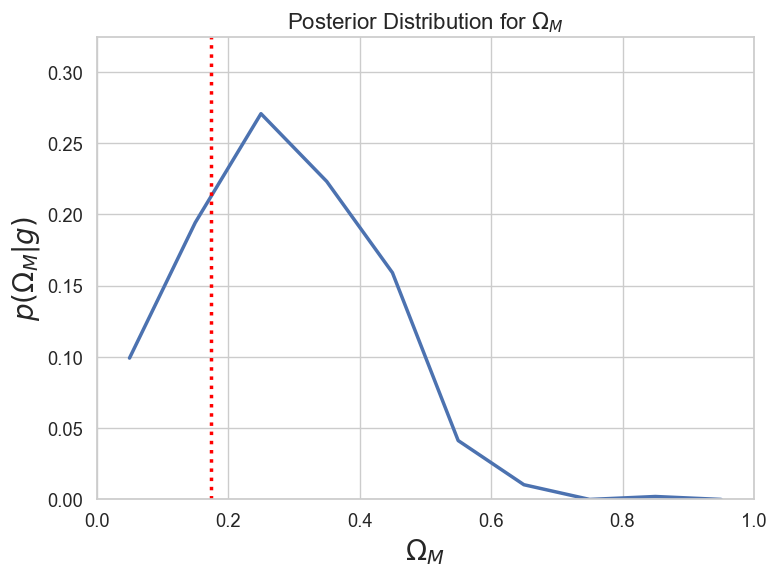

<Figure size 800x600 with 0 Axes>

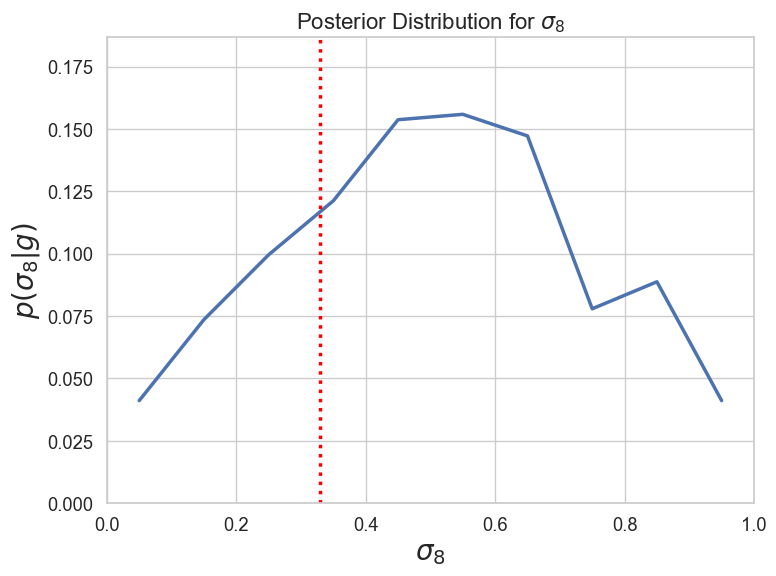

<Figure size 800x600 with 0 Axes>

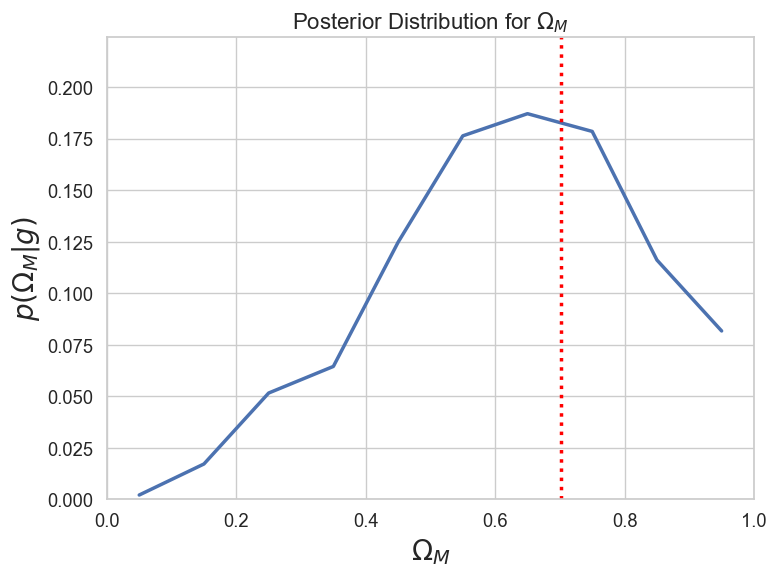

<Figure size 800x600 with 0 Axes>

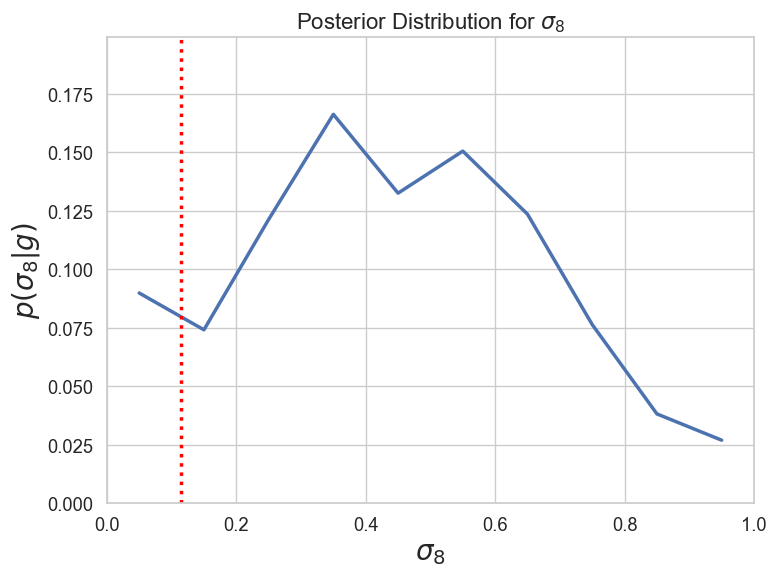

<Figure size 800x600 with 0 Axes>

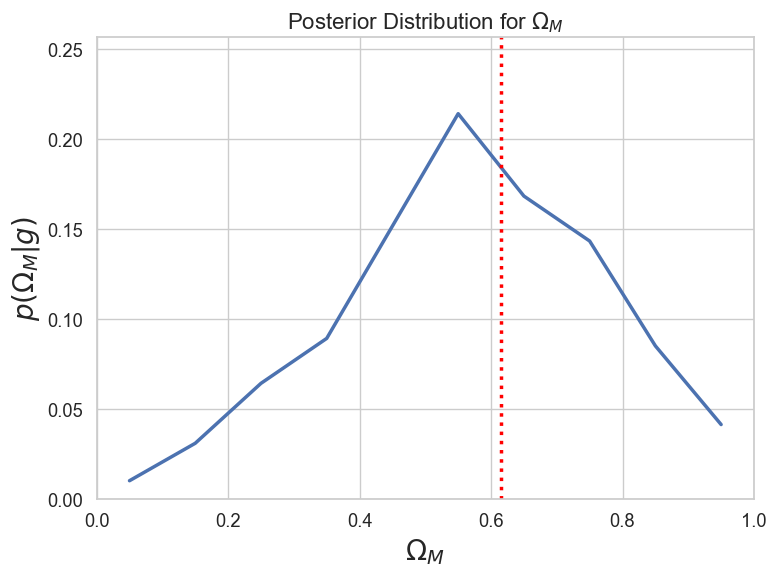

<Figure size 800x600 with 0 Axes>

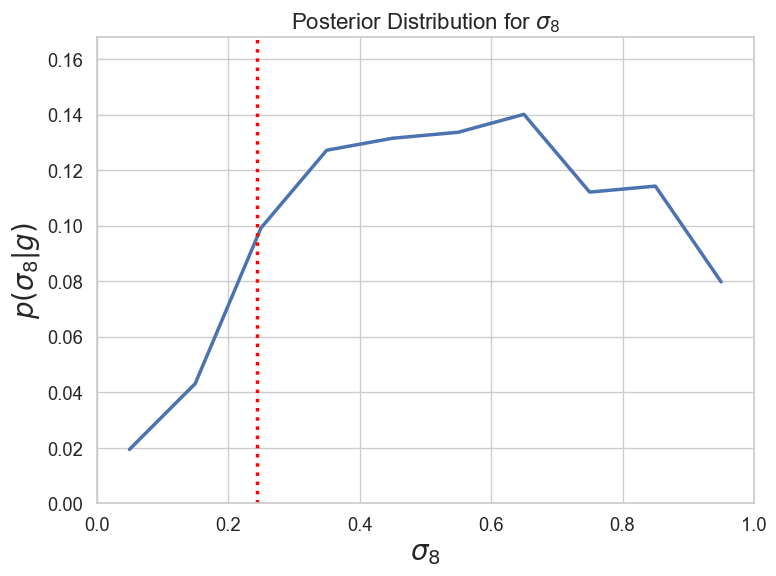

<Figure size 800x600 with 0 Axes>

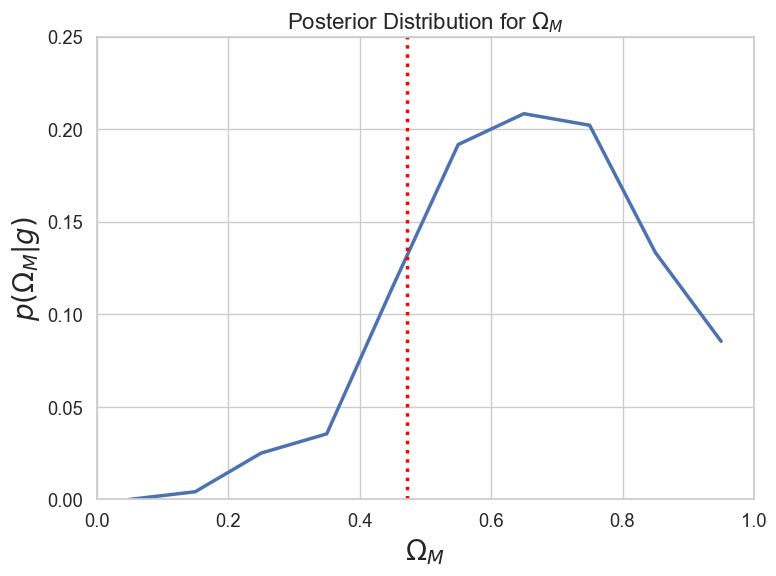

<Figure size 800x600 with 0 Axes>

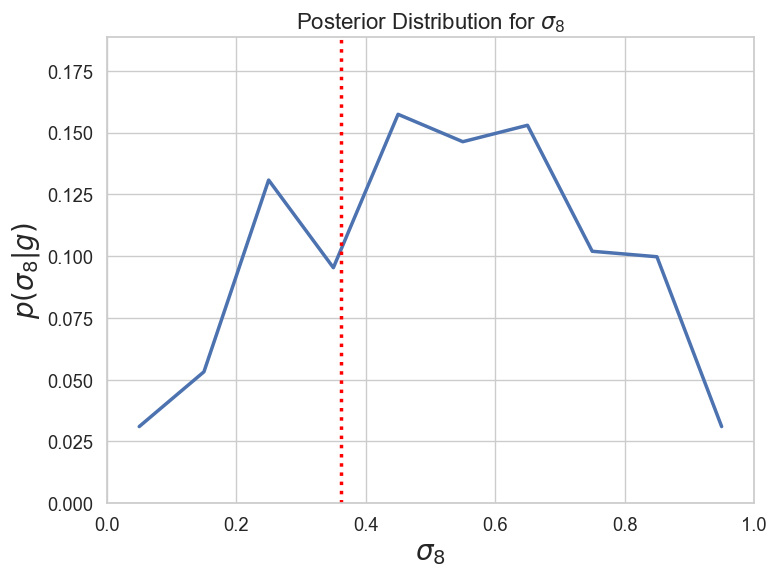

<Figure size 800x600 with 0 Axes>

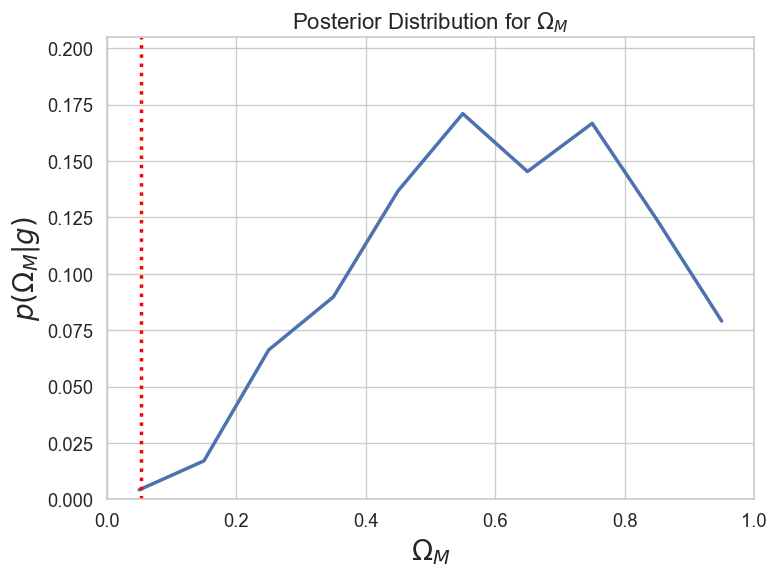

<Figure size 800x600 with 0 Axes>

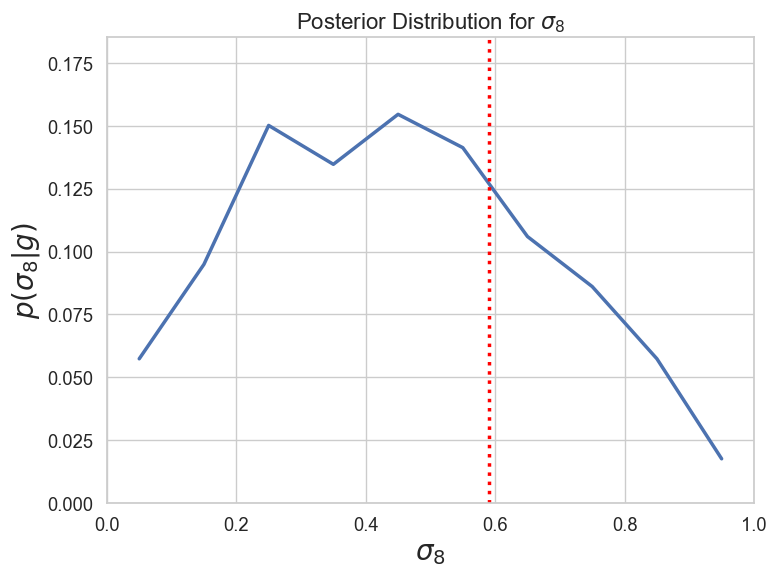

In [147]:
import seaborn as sns
dset_test = input_fn_omega_sigma8(mode='test')
iterator = iter(dset_test)

nexamples=1
for b in range(nexamples):
    batch = iterator.get_next()
    nsamples=500
    omega_pred_samples=[]
    sigma8_pred_samples=[]
    for i in range(nsamples):
        omega_pred_samples.append((mdn_multivariate(batch[0]).sample())[b,0])
        sigma8_pred_samples.append((mdn_multivariate(batch[0]).sample())[b,1])


    # Create a normalized histogram using Seaborn
    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(8, 6))




    # Compute the PDF using a normalized histogram
    hist, bin_edges = np.histogram(np.squeeze(np.array(omega_pred_samples)), bins=10, density=True,range=(0, 1))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    pdf = hist * np.diff(bin_edges)

    # Create a line plot using Seaborn
    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(8, 6))

    # Plot the PDF as a line plot
    sns.lineplot(x=bin_centers, y=pdf, color="b")
    plt.xlabel(r"$\Omega_M$", fontsize=20)
    plt.ylabel(r"$p(\Omega_M|g)$", fontsize=20)
    plt.title("Posterior Distribution for $\Omega_M$", fontsize=16)
    plt.xlim(0, 1)
    plt.ylim(0, max(pdf) * 1.2)  # Adjust y-axis limits as needed

    plt.axvline(x=batch[1][b,0],color='red',ls=':')

    # Save or show the plot
    plt.tight_layout()
    plt.savefig("omega_pdf_plot.png")  # Save the plot to a file
    plt.show()  # Display the plot
    
    
        # Create a normalized histogram using Seaborn
    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(8, 6))




    # Compute the PDF using a normalized histogram
    hist, bin_edges = np.histogram(np.squeeze(np.array(sigma8_pred_samples)), bins=10, density=True,range=(0, 1))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    pdf = hist * np.diff(bin_edges)

    # Create a line plot using Seaborn
    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(8, 6))

    # Plot the PDF as a line plot
    sns.lineplot(x=bin_centers, y=pdf, color="b")
    plt.xlabel(r"$\sigma_8$", fontsize=20)
    plt.ylabel(r"$p(\sigma_8|g)$", fontsize=20)
    plt.title("Posterior Distribution for $\sigma_8$", fontsize=16)
    plt.xlim(0, 1)
    plt.ylim(0, max(pdf) * 1.2)  # Adjust y-axis limits as needed

    #print(batch)
    plt.axvline(x=batch[1][b,1],color='red',ls=':')

    # Save or show the plot
    plt.tight_layout()
    plt.savefig("sigma8_pdf_plot.png")  # Save the plot to a file
    plt.show() 
    
    
    

Make a corner plot

2023-08-20 16:54:16.481953: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


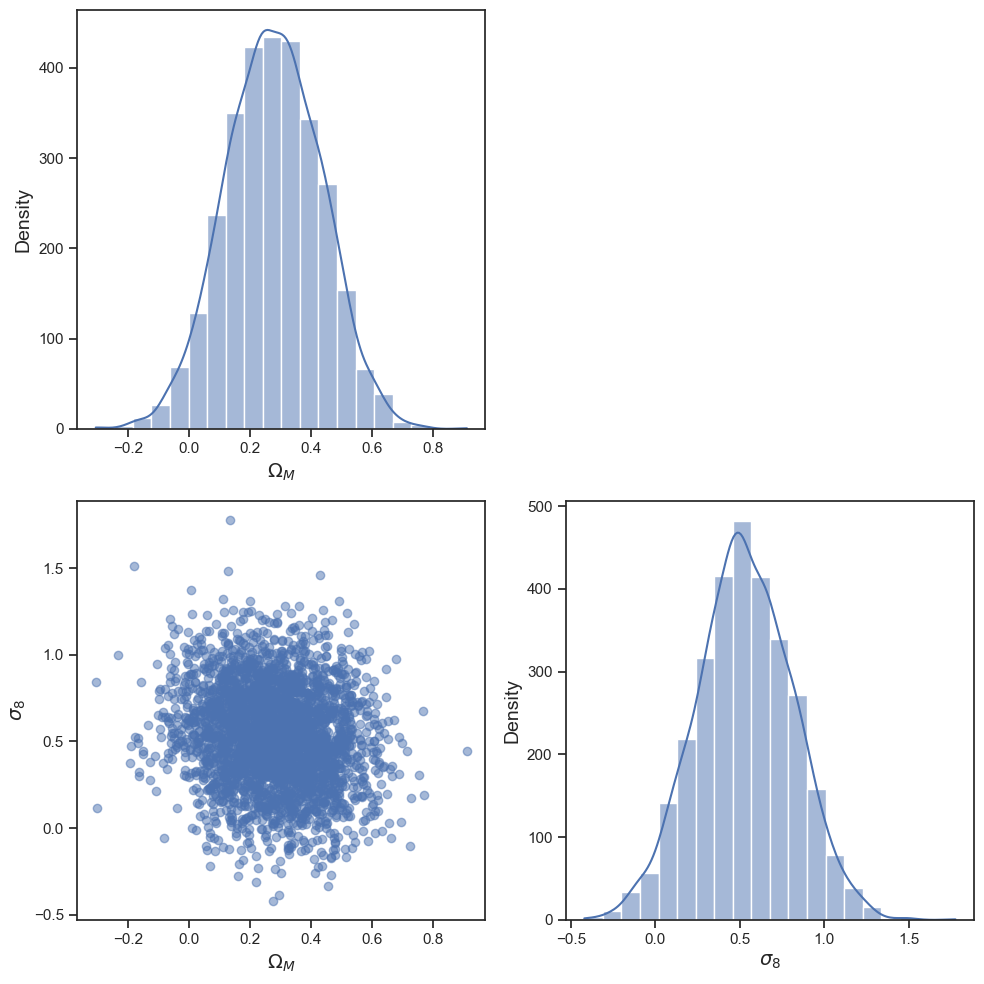

In [148]:

# Create the test dataset
dset_test = input_fn_omega_sigma8(mode='test')
iterator = iter(dset_test)
batch = iterator.get_next()

nsamples=3000
nplots = 1
# Generate samples from the model
for b in range(nplots):
    # Lists to store samples
    omega_pred_samples = []
    sigma8_pred_samples = []
    for i in range(nsamples):
        samples = mdn_multivariate(batch[0]).sample()[b]
        omega_pred_samples.append(samples[0])
        sigma8_pred_samples.append(samples[1])

    # Combine the samples into a matrix
    samples_matrix = np.vstack((omega_pred_samples, sigma8_pred_samples)).T

    # Create a corner plot
    sns.set(style="ticks")
    corner_labels = [r"$\Omega_M$", r"$\sigma_8$"]
    plt.figure(figsize=(10, 10))

    # Create scatter plots for the lower diagonal
    for i in range(2):
        for j in range(i + 1):
            plt.subplot(2, 2, i * 2 + j + 1)
            if i == j:
                sns.histplot(samples_matrix[:, i], bins=20, kde=True, color="b")
                plt.xlabel(corner_labels[i], fontsize=14)
                plt.ylabel("Density", fontsize=14)
            else:
                plt.scatter(samples_matrix[:, j], samples_matrix[:, i], color="b", alpha=0.5)
                plt.xlabel(corner_labels[j], fontsize=14)
                plt.ylabel(corner_labels[i], fontsize=14)

    plt.tight_layout()
    plt.show()
